- https://habr.com/ru/articles/716342/
- https://scipython.com/blog/the-forest-fire-model/

Cells take one of three states: **water** (-3), **bedrock** (-2), **burned** (-1), **grass** (0), **occupied by a tree** (1), **fire** (2) and **cloud** (3).

1. A burning cell turns into an empty cell
2. A cell occupied by a tree becomes a burning cell if any of its eight neighbouring cells are burning
3. A cell occupied by a tree becomes burning with a probabilty ***f*** (even if none of its neighbouring cells are burning), as though struck by lightning
5. An empty cell becomes occupied by a tree with probability ***p***.

**Ideas**:
- ~Add water cells (generated in groups, i.e. if there is a water cell it will highly increase the proba);~
- ~Add weather parameters (temperature, wind dir);~
- ~Add grass, which grows faster;~
- ~Add a cumulus passing by and putting out the fire; (a cloud covers 16 pixels)~
- ~Add metrics of tree/grass/fire coverage and temperature;~

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib.patches import Rectangle

from datetime import timedelta,datetime

# Simple Simulation

In [6]:
class WFSim:
    def __init__(self, f=0.01, p=1e-4, h=16, w=16):
        self.f = f #fire proba
        self.p = p #tree growing proba
        self.h = h #grid height
        self.w = w #grid width

        self.landscape = np.random.randint(1,2,(self.h,self.w)) #generating grid

    def fire_neighbors_check(self, idx, jdx):
        check = False
        offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        #offsets = coordinates of all the neighbors of a cell (0,0)

        for di,dj in offsets: #checking if any of the neighbors have fire
            ni, nj = idx+di, jdx+dj
            if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                if self.landscape[ni, nj] == 2:
                    check +=True
        return check

    def step(self, step):

        new_landscape = self.landscape.copy()

        for i in range(self.landscape.shape[0]):
            for j in range(self.landscape.shape[1]):

                if self.landscape[i, j]==2:
                    new_landscape[i, j] = 0 #ash after fire
                
                if self.p > np.random.rand() and self.landscape[i, j]==0:
                    new_landscape[i, j] = 1 #growing a tree
                    
                if (self.f > np.random.rand() or self.fire_neighbors_check(i, j)) and self.landscape[i, j]==1:
                    new_landscape[i, j] = 2 #firing a tree
        self.landscape = new_landscape.copy()

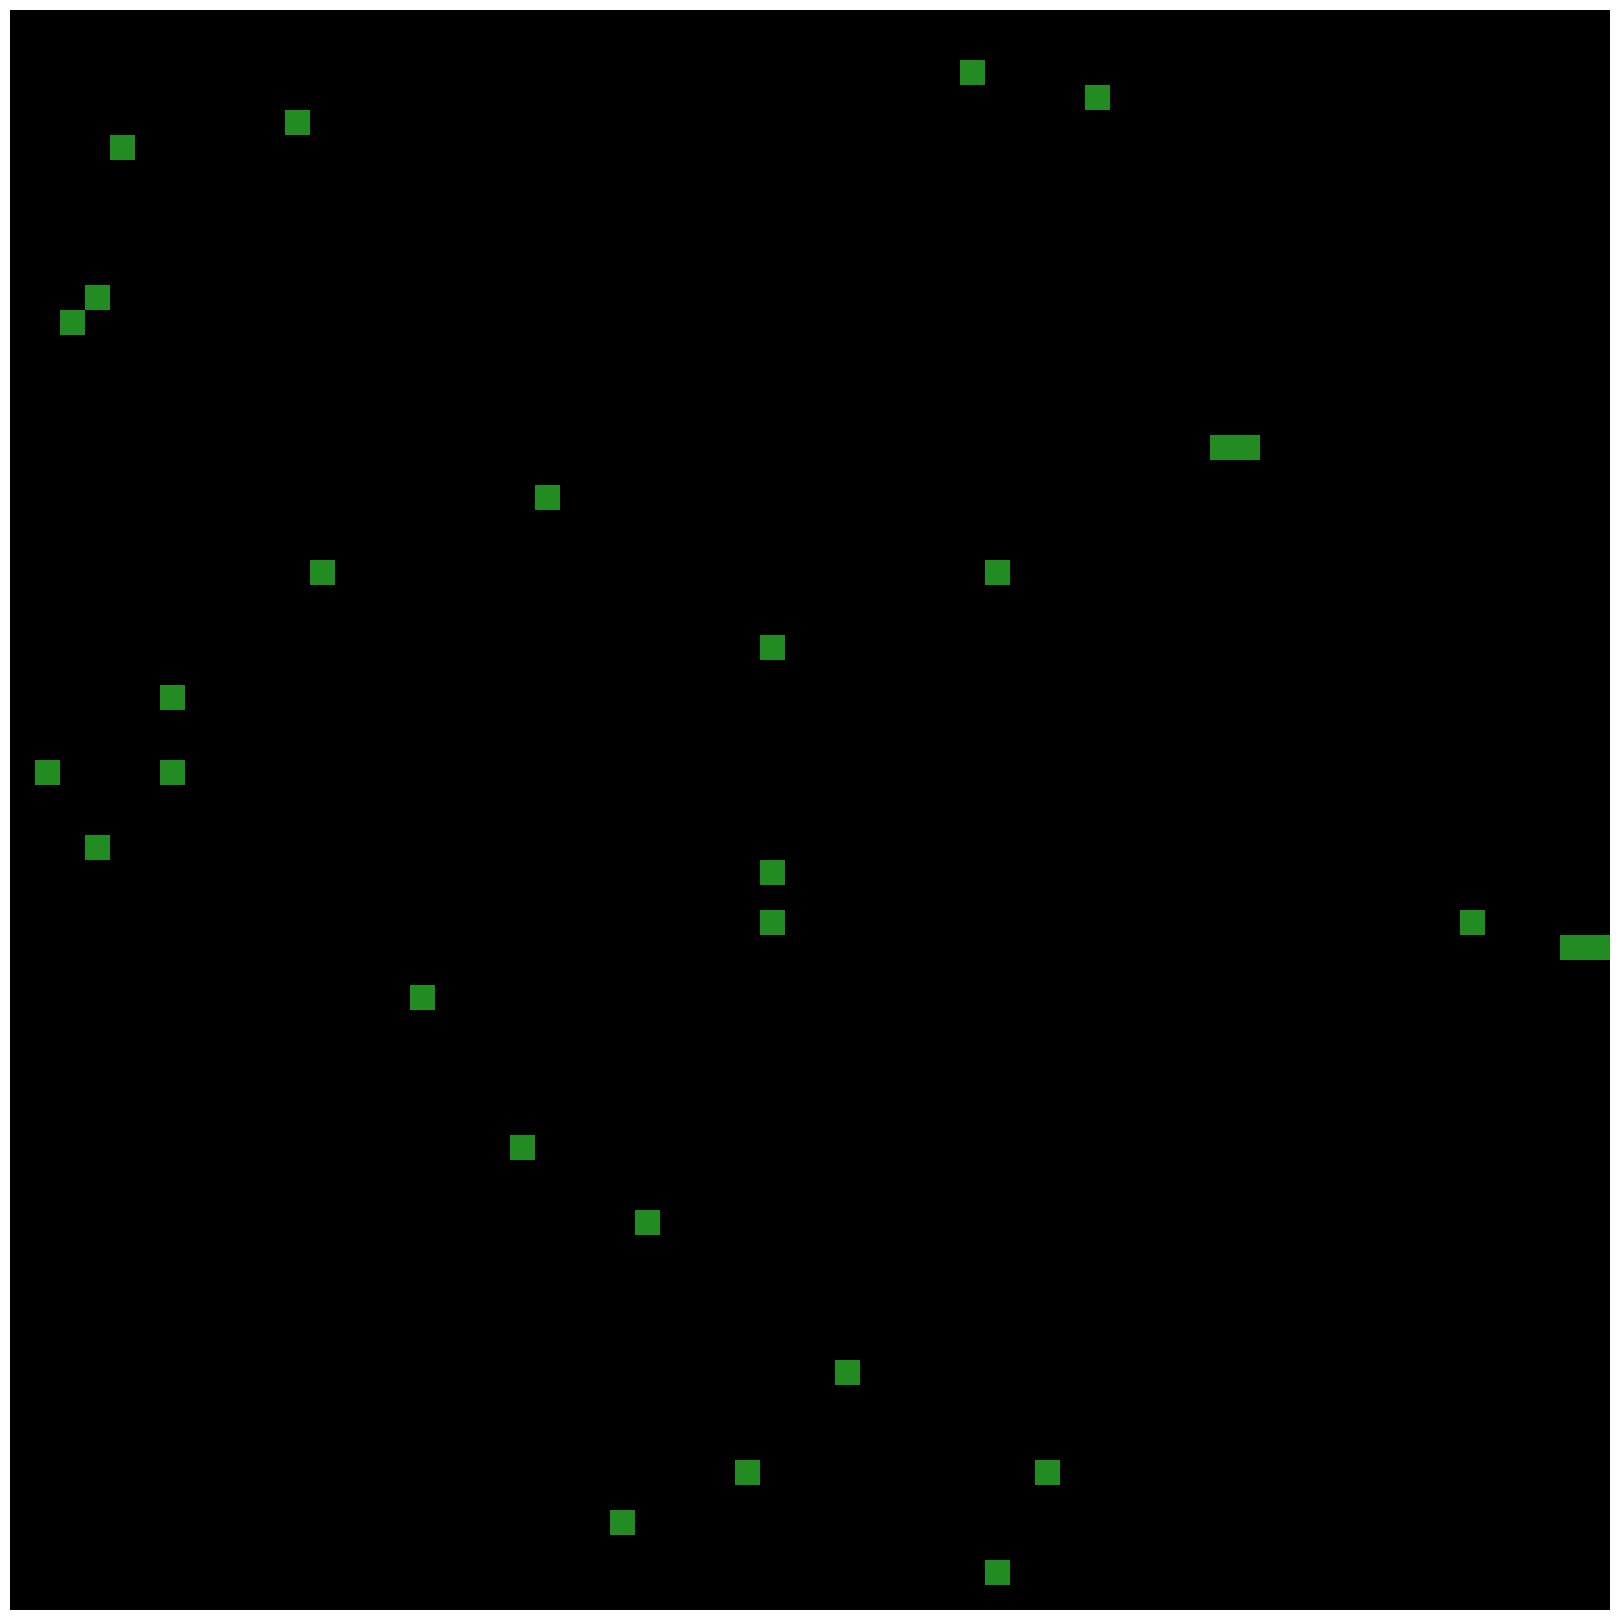

In [7]:
def update(frame):
    im.set_data(Sim.landscape)
    ax.axis('off')
    Sim.step(frame)
    return [im]

colors_list = ['black',  'forestgreen', 'orange'] #setting cell colors
cmap = colors.ListedColormap(colors_list)
bounds = [0,1,2,3]  
  
Sim = WFSim(h=64, w=64) #initializing the simulation

fig, ax = plt.subplots(figsize=(16,16))
im = ax.imshow(Sim.landscape, cmap=cmap, norm=norm)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

ani = animation.FuncAnimation(fig, update, frames=80, interval=20) #frames - the number of steps in the simulation
ani.save('simple.gif', fps=1.5, savefig_kwargs={'pad_inches':0})
plt.show()

# Adding cell states

In [41]:
class WFSim:
    def __init__(self, f=0.01, p=1e-4, bedrock=0.005, water=0.05, h=16, w=16):
        self.f = f #fire proba
        self.p = p #tree growing proba
        self.h = h #grid height
        self.w = w #grid width
        self.bedrock = bedrock #bedrock proba
        self.water = water #water proba
        
        self.landscape = np.random.randint(0,2,(self.h,self.w)) #0 - grass, 1 - tree

        for i in range(self.landscape.shape[0]):
            for j in range(self.landscape.shape[1]):
                coef = 5 if self.surf_neighbors_check(i, j, "B") else 1
                if self.bedrock*coef>np.random.random():
                    self.landscape[i, j] = -2     

                coef = 10 if self.surf_neighbors_check(i, j, "W") else 0.1
                if self.water*coef>np.random.random():
                    self.landscape[i, j] = -3 
                    
    def surf_neighbors_check(self, idx, jdx, kind='W'):
        if kind=='W':
            value = -2
        elif kind=='B':
            value = -1
        check = False
        offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        for di,dj in offsets:
            ni, nj = idx+di, jdx+dj
            if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                if self.landscape[ni, nj] == value:
                    check +=True
        return check
        
    def fire_neighbors_check(self, idx, jdx):
        check = False
        offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        #offsets = coordinates of all the neighbors of a cell (0,0)

        for di,dj in offsets: #checking if any of the neighbors have fire
            ni, nj = idx+di, jdx+dj
            if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                if self.landscape[ni, nj] == 2:
                    check +=True
        return check

    def step(self, step):

        new_landscape = self.landscape.copy()

        for i in range(self.landscape.shape[0]):
            for j in range(self.landscape.shape[1]):

                if self.landscape[i, j]==2:
                    new_landscape[i, j] = -1 #ash after fire
                
                if self.p > np.random.rand() and self.landscape[i, j]==0:
                    new_landscape[i, j] = 1 #growing a tree
                    
                if (self.f > np.random.rand() or self.fire_neighbors_check(i, j)) and self.landscape[i, j]==1:
                    new_landscape[i, j] = 2 #firing a tree
        self.landscape = new_landscape.copy()

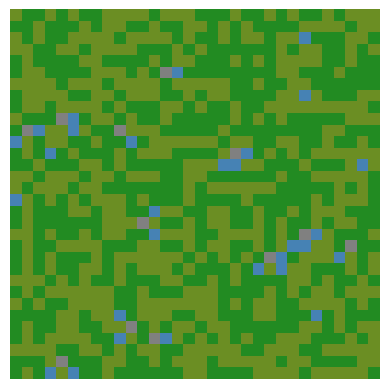

In [42]:
colors_list = ['steelblue', 'grey','black', 'olivedrab', 'forestgreen', 'orange']
cmap = colors.ListedColormap(colors_list)
bounds = [-3, -2, -1, 0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

Sim = WFSim(h=32, w=32)
plt.imshow(Sim.landscape, cmap=cmap, norm=norm)
plt.axis(False)
plt.savefig('Landscape.png', pad_inches=0, bbox_inches='tight')
plt.show()

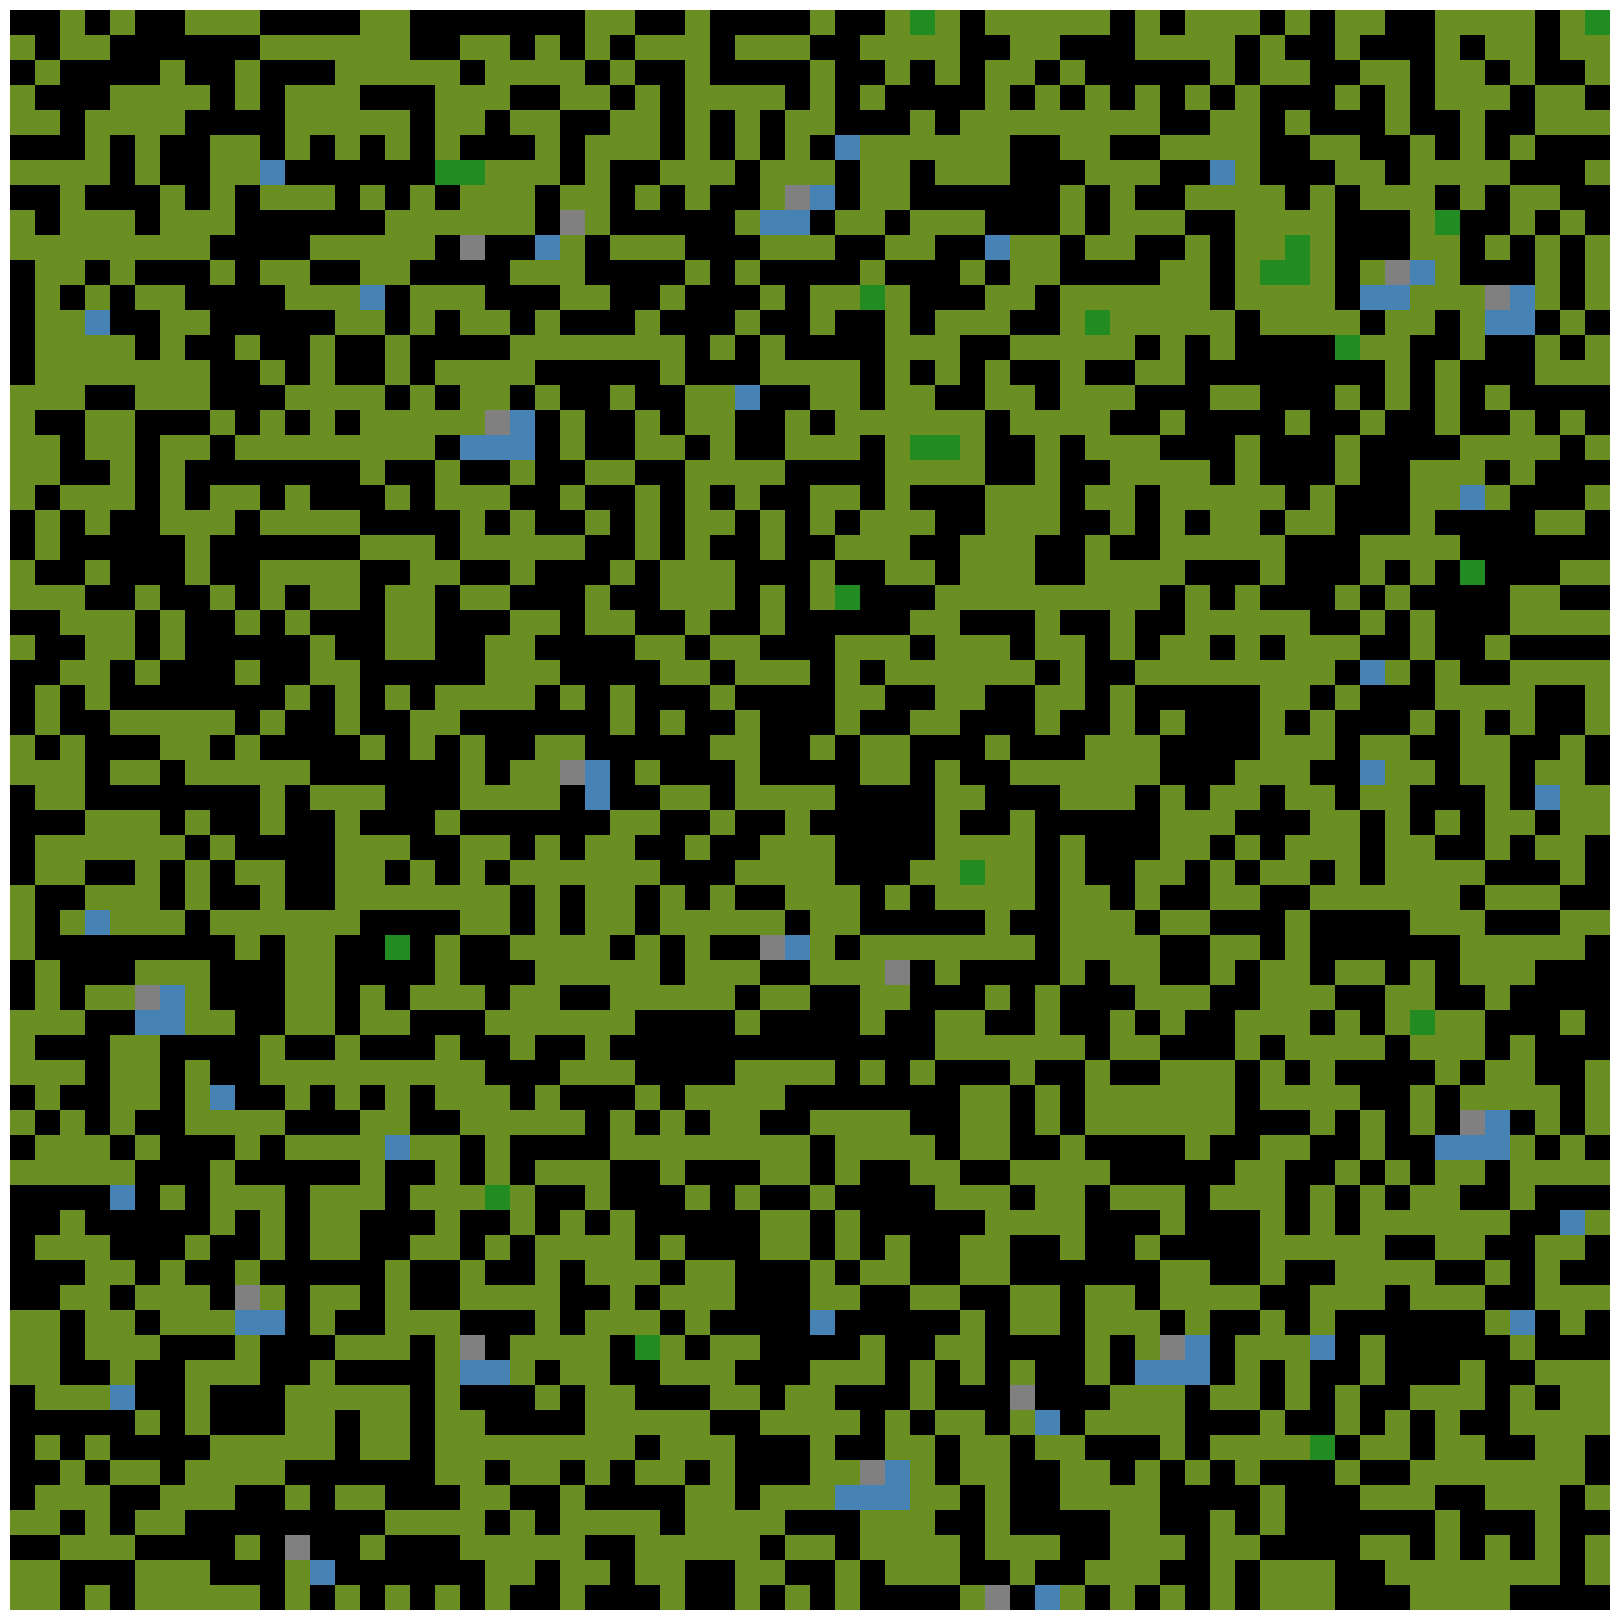

In [43]:
def update(frame):
    im.set_data(Sim.landscape)
    ax.axis('off')
    Sim.step(frame)
    return [im]

colors_list = ['steelblue', 'grey','black', 'olivedrab', 'forestgreen', 'orange']
cmap = colors.ListedColormap(colors_list)
bounds = [-3, -2, -1, 0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

Sim = WFSim(h=64, w=64) #initializing the simulation

fig, ax = plt.subplots(figsize=(16,16))
im = ax.imshow(Sim.landscape, cmap=cmap, norm=norm)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

ani = animation.FuncAnimation(fig, update, frames=80, interval=20) #frames - the number of steps in the simulation
ani.save('new_states.gif', fps=1.5, savefig_kwargs={'pad_inches':0})
plt.show()

# Tempearature

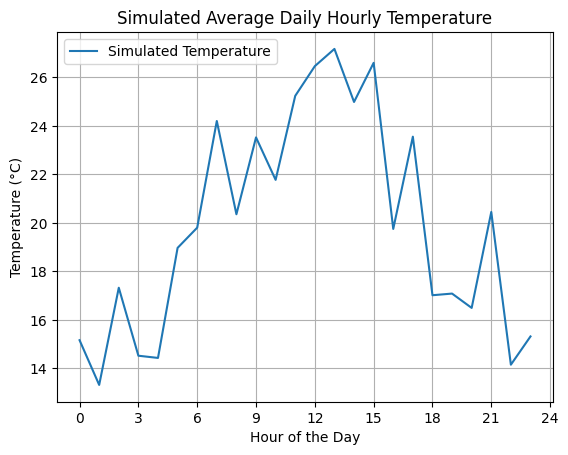

In [48]:
average_temp = 20 
amplitude = 5 
noise_level = 2    
hours_in_day = 24

hours = np.arange(hours_in_day)
temperatures = average_temp + amplitude * np.sin(2 * np.pi * hours / 24 - np.pi / 2)

temperatures += np.random.normal(0, noise_level, 24) #noise

plt.plot(hours, temperatures, label='Simulated Temperature')
plt.xlabel('Hour of the Day')
plt.ylabel('Temperature (°C)')
plt.title('Simulated Average Daily Hourly Temperature')
plt.xticks(np.arange(0, 25, 3))
plt.legend()
plt.grid(True)
plt.savefig('temperature.png')
plt.show()

In [51]:
class WFSim:
    def __init__(self, f=0.01, p=1e-4, bedrock=0.005, water=0.05, h=16, w=16):
        self.f = f #fire proba
        self.p = p #tree growing proba
        self.h = h #grid height
        self.w = w #grid width
        self.bedrock = bedrock #bedrock proba
        self.water = water #water proba
        self.temp = self.temperature()
        
        self.landscape = np.random.randint(0,2,(self.h,self.w)) #0 - grass, 1 - tree

        for i in range(self.landscape.shape[0]):
            for j in range(self.landscape.shape[1]):
                coef = 5 if self.surf_neighbors_check(i, j, "B") else 1
                if self.bedrock*coef>np.random.random():
                    self.landscape[i, j] = -2     

                coef = 10 if self.surf_neighbors_check(i, j, "W") else 0.1
                if self.water*coef>np.random.random():
                    self.landscape[i, j] = -3 
                    
    def surf_neighbors_check(self, idx, jdx, kind='W'):
        if kind=='W':
            value = -2
        elif kind=='B':
            value = -1
        check = False
        offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        for di,dj in offsets:
            ni, nj = idx+di, jdx+dj
            if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                if self.landscape[ni, nj] == value:
                    check +=True
        return check
        
    def fire_neighbors_check(self, idx, jdx):
        check = False
        offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        #offsets = coordinates of all the neighbors of a cell (0,0)

        for di,dj in offsets: #checking if any of the neighbors have fire
            ni, nj = idx+di, jdx+dj
            if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                if self.landscape[ni, nj] == 2:
                    check +=True
        return check
        
    def temperature(self,average_temp=20, amplitude=5, noise_level=2):
        hours = np.arange(24)
        temperatures = average_temp + amplitude * np.sin(2 * np.pi * hours / 24 - np.pi / 2)
        
        temperatures += np.random.normal(0, noise_level, 24)

        return temperatures

    def step(self, step):
        
        if step%24==0 and step>0:
            self.temp = self.temperature()
            
        new_landscape = self.landscape.copy()

        for i in range(self.landscape.shape[0]):
            for j in range(self.landscape.shape[1]):

                if self.landscape[i, j]==2:
                    new_landscape[i, j] = -1 #ash after fire
                
                if self.p > np.random.rand() and self.landscape[i, j]==0:
                    new_landscape[i, j] = 1 #growing a tree
                    
                coef = 2 if self.temp[step%24]>25 else 1
                if (self.f*coef > np.random.rand() or self.fire_neighbors_check(i, j)) and self.landscape[i, j]==1:
                    new_landscape[i, j] = 2 #firing a tree
        self.landscape = new_landscape.copy()

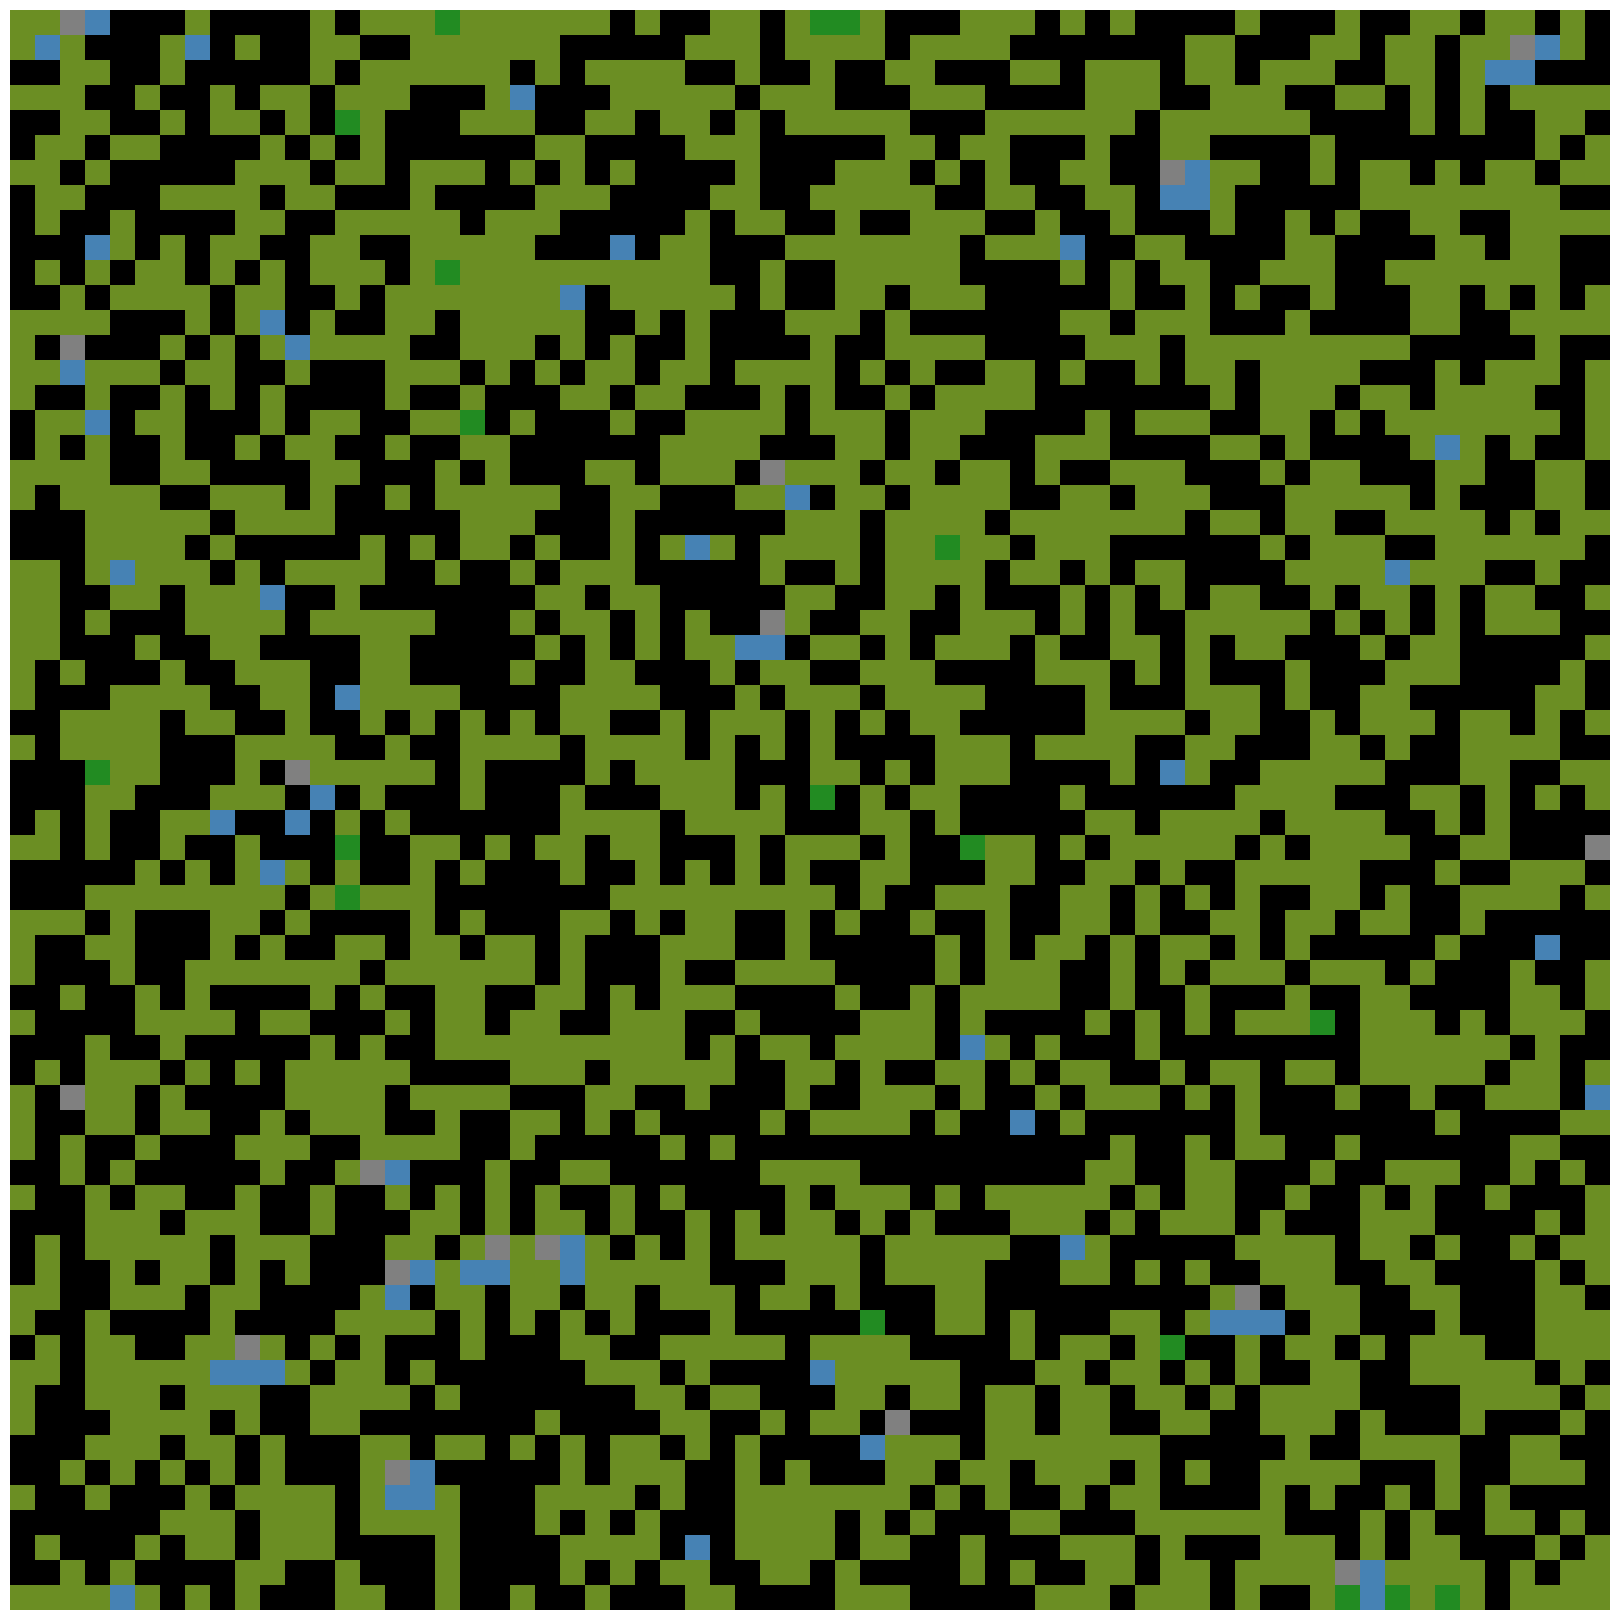

In [52]:
def update(frame):
    im.set_data(Sim.landscape)
    ax.axis('off')
    Sim.step(frame)
    return [im]

colors_list = ['steelblue', 'grey','black', 'olivedrab', 'forestgreen', 'orange']
cmap = colors.ListedColormap(colors_list)
bounds = [-3, -2, -1, 0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

Sim = WFSim(h=64, w=64) #initializing the simulation

fig, ax = plt.subplots(figsize=(16,16))
im = ax.imshow(Sim.landscape, cmap=cmap, norm=norm)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

ani = animation.FuncAnimation(fig, update, frames=80, interval=20) #frames - the number of steps in the simulation
ani.save('temperature.gif', fps=1.5, savefig_kwargs={'pad_inches':0})
plt.show()

# Wind

In [56]:
class WFSim:
    def __init__(self, f=0.01, p=1e-4, bedrock=0.005, water=0.05, h=16, w=16):
        self.f = f #fire proba
        self.p = p #tree growing proba
        self.h = h #grid height
        self.w = w #grid width
        self.bedrock = bedrock #bedrock proba
        self.water = water #water proba
        self.temp = self.temperature()
        self.wind = np.random.choice(['calm', 'S', 'N', 'W', 'E', 'SW', 'SE', 'NW', 'NE'])
        self.offsets = {'calm': [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)],
                         'N': [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1)],
                         'S': [(0,-1),(0,1),(1,-1),(1,0),(1,1)], 
                         'E': [(-1,0),(-1,1),(0,1),(1,0),(1,1)],
                         'W': [(-1,-1),(-1,0),(0,-1),(1,-1),(1,0)],
                         'NE': [(-1,0),(-1,1),(0,1)],
                         'NW': [(-1,-1),(-1,0),(0,-1)],
                         'SE': [(0,1),(1,0),(1,1)],
                         'SW': [(0,-1),(1,-1),(1,0)]}
        
        self.landscape = np.random.randint(0,2,(self.h,self.w)) #0 - grass, 1 - tree

        for i in range(self.landscape.shape[0]):
            for j in range(self.landscape.shape[1]):
                coef = 5 if self.surf_neighbors_check(i, j, "B") else 1
                if self.bedrock*coef>np.random.random():
                    self.landscape[i, j] = -2     

                coef = 10 if self.surf_neighbors_check(i, j, "W") else 0.1
                if self.water*coef>np.random.random():
                    self.landscape[i, j] = -3 
                    
    def surf_neighbors_check(self, idx, jdx, kind='W'):
        if kind=='W':
            value = -2
        elif kind=='B':
            value = -1
        check = False
        offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        for di,dj in offsets:
            ni, nj = idx+di, jdx+dj
            if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                if self.landscape[ni, nj] == value:
                    check +=True
        return check
        
    def fire_neighbors_check(self, idx, jdx):
        check = False
        offsets = self.offsets[self.wind]
        #offsets = coordinates of all the neighbors of a cell (0,0)

        for di,dj in offsets: #checking if any of the neighbors have fire
            ni, nj = idx+di, jdx+dj
            if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                if self.landscape[ni, nj] == 2:
                    check +=True
        return check
        
    def temperature(self,average_temp=20, amplitude=5, noise_level=2):
        hours = np.arange(24)
        temperatures = average_temp + amplitude * np.sin(2 * np.pi * hours / 24 - np.pi / 2)
        
        temperatures += np.random.normal(0, noise_level, 24)

        return temperatures

    def step(self, step):
        
        if step%24==0 and step>0:
            self.temp = self.temperature()
            
        new_landscape = self.landscape.copy()

        for i in range(self.landscape.shape[0]):
            for j in range(self.landscape.shape[1]):

                if self.landscape[i, j]==2:
                    new_landscape[i, j] = -1 #ash after fire
                
                if self.p > np.random.rand() and self.landscape[i, j]==0:
                    new_landscape[i, j] = 1 #growing a tree
                    
                coef = 2 if self.temp[step%24]>25 else 1
                if (self.f*coef > np.random.rand() or self.fire_neighbors_check(i, j)) and self.landscape[i, j]==1:
                    new_landscape[i, j] = 2 #firing a tree
        self.landscape = new_landscape.copy()

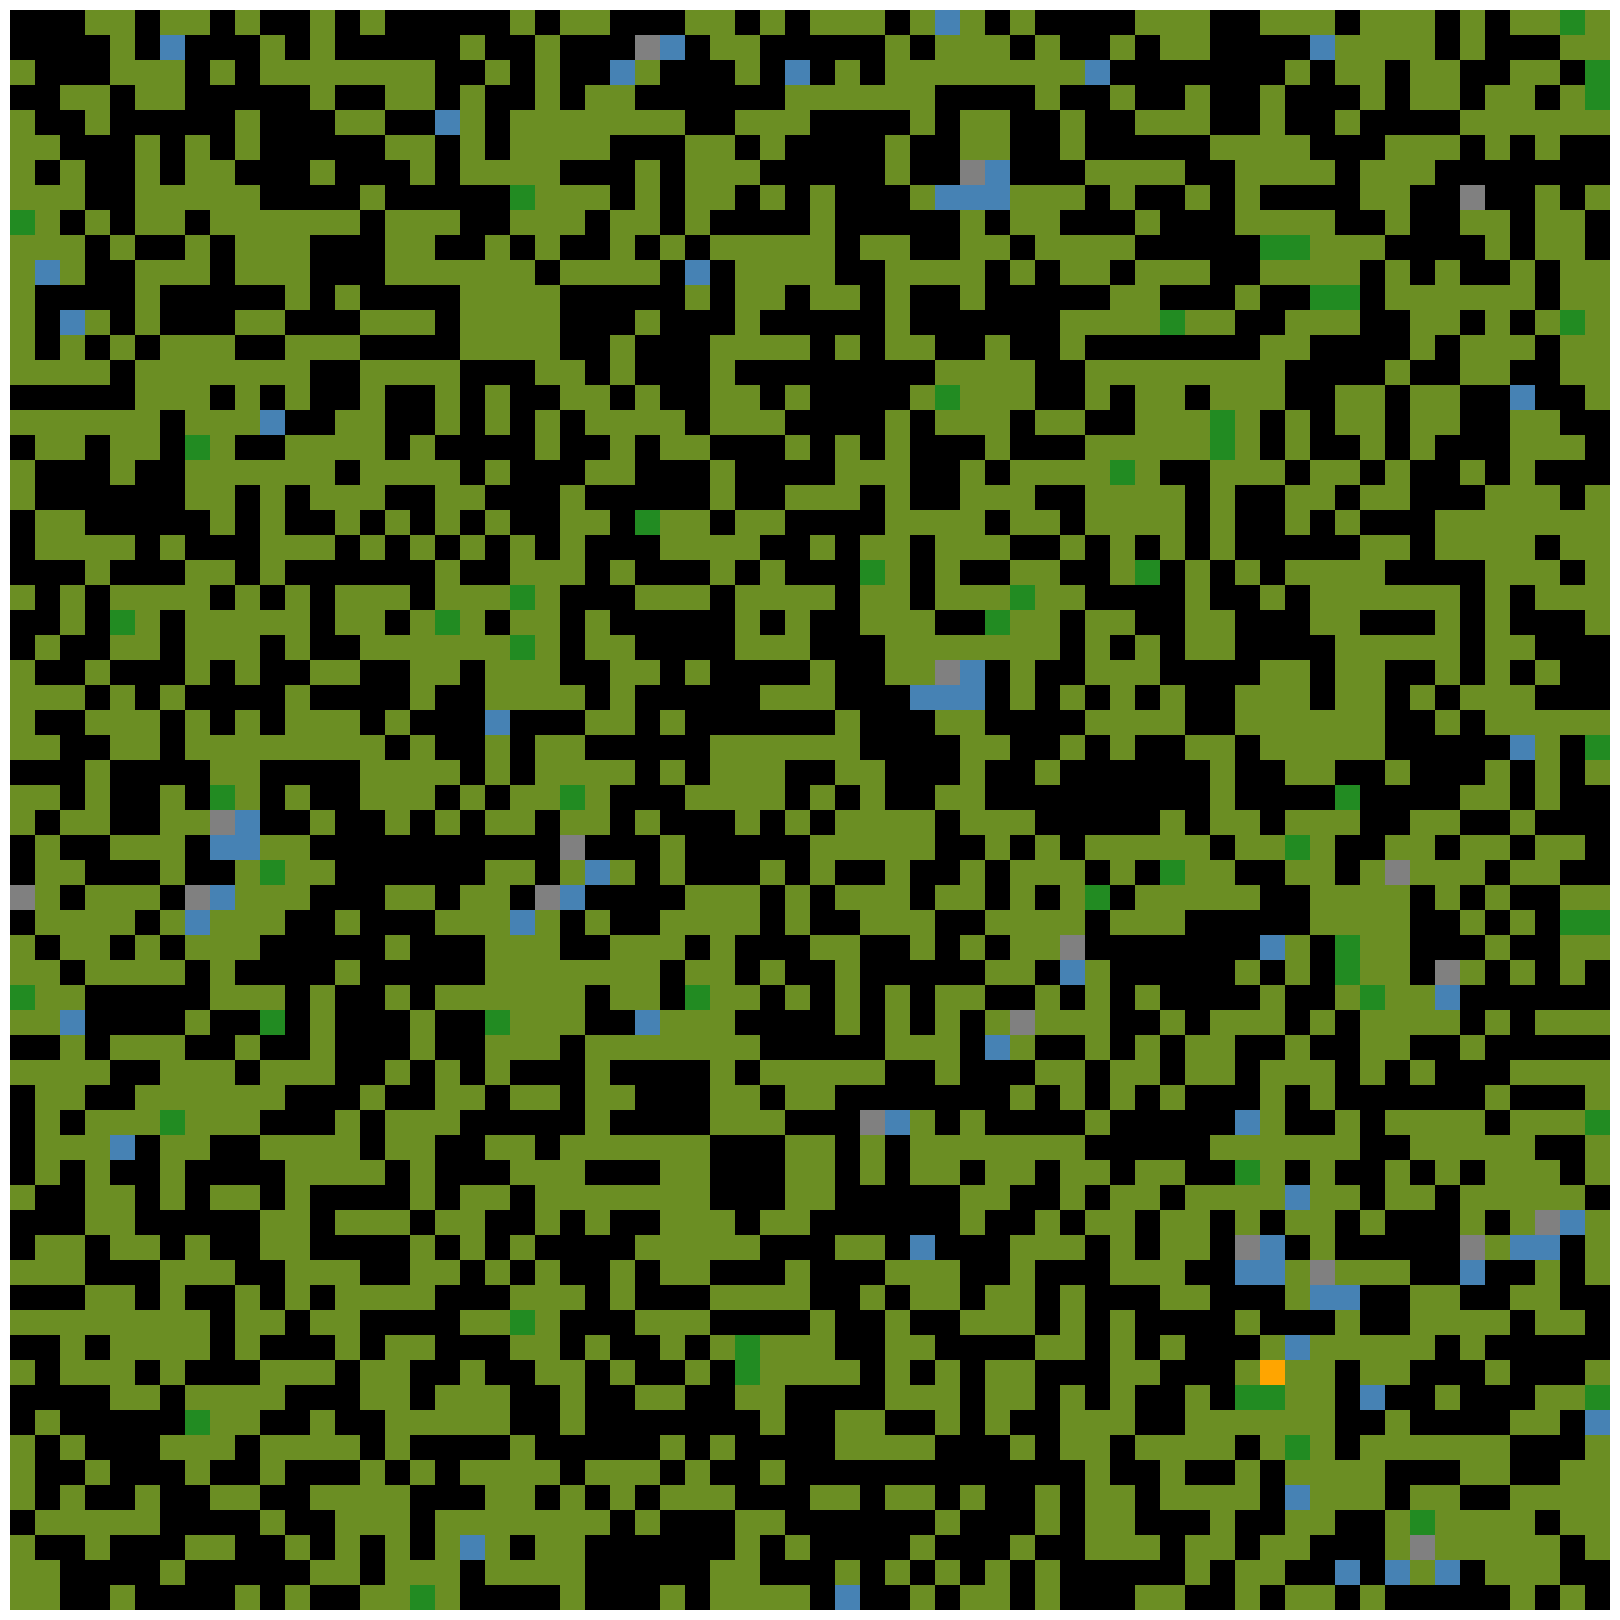

In [57]:
def update(frame):
    im.set_data(Sim.landscape)
    ax.axis('off')
    Sim.step(frame)
    return [im]

colors_list = ['steelblue', 'grey','black', 'olivedrab', 'forestgreen', 'orange']
cmap = colors.ListedColormap(colors_list)
bounds = [-3, -2, -1, 0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

Sim = WFSim(h=64, w=64) #initializing the simulation

fig, ax = plt.subplots(figsize=(16,16))
im = ax.imshow(Sim.landscape, cmap=cmap, norm=norm)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

ani = animation.FuncAnimation(fig, update, frames=80, interval=20) #frames - the number of steps in the simulation
ani.save('wind.gif', fps=1.5, savefig_kwargs={'pad_inches':0})
plt.show()

# Final Simulation

In [74]:
class WFSim:
    def __init__(self, f=0.01, p=1e-4, wind='NE', bedrock=0.005, water=0.05, grass=0.1, cloud=0.1, h=16, w=16):
        self.f = f
        self.p = p
        self.h = h
        self.w = w
        self.bedrock = bedrock
        self.water = water
        self.wind = wind#np.random.choice(['calm', 'S', 'N', 'W', 'E', 'SW', 'SE', 'NW', 'NE'])
        self.cloud = np.random.random(1)[0]
        self.temp = self.temperature()
        
        self.offsets = {'calm': [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)],
                         'N': [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1)],
                         'S': [(0,-1),(0,1),(1,-1),(1,0),(1,1)], 
                         'E': [(-1,0),(-1,1),(0,1),(1,0),(1,1)],
                         'W': [(-1,-1),(-1,0),(0,-1),(1,-1),(1,0)],
                         'NE': [(-1,0),(-1,1),(0,1)],
                         'NW': [(-1,-1),(-1,0),(0,-1)],
                         'SE': [(0,1),(1,0),(1,1)],
                         'SW': [(0,-1),(1,-1),(1,0)]}

        self.cloud_offsets = {'calm': [],
                         'N': [(1,0)],
                         'S': [(-1,0)], 
                         'E': [(0,-1)],
                         'W': [(0,1)],
                         'NE': [(1,-1)],
                         'NW': [(1,1)],
                         'SE': [(-1,-1)],
                         'SW': [(-1,1)]}
        
        self.landscape = np.random.randint(0,2,(self.h,self.w))#0,2
        self.old_landscape = self.landscape.copy()
        
        self.burned_ratio = round((self.landscape==-1).sum()/(self.h*self.w)*100,2)
        self.tree_cover = round((self.landscape==1).sum()/(self.h*self.w)*100,2)
        
        for i in range(self.landscape.shape[0]):
            for j in range(self.landscape.shape[1]):
                coef = 4 if self.surf_neighbors_check(i, j, "B") else 1
                if self.bedrock*coef>np.random.random():
                    self.landscape[i, j] = -2     

                coef = 10 if self.surf_neighbors_check(i, j, "W") else 0.1
                if self.water*coef>np.random.random():
                    self.landscape[i, j] = -3 

    def fire_neighbors_check(self, idx, jdx):
        check = False
        
        offsets = self.offsets[self.wind]

        for di,dj in offsets:
            ni, nj = idx+di, jdx+dj
            if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                if self.landscape[ni, nj] == 2 and self.landscape[idx, jdx] == 1:
                    check +=True
        return check

    def surf_neighbors_check(self, idx, jdx, kind='W'):
        if kind=='W':
            value = -2
        elif kind=='B':
            value = -1
        check = False
        offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        for di,dj in offsets:
            ni, nj = idx+di, jdx+dj
            if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                if self.landscape[ni, nj] == value:
                    check +=True
        return check
    
    def temperature(self,average_temp=20, amplitude=5, noise_level=2):
        hours = np.arange(24)
        temperatures = average_temp + amplitude * np.sin(2 * np.pi * hours / 24 - np.pi / 2)
        
        temperatures += np.random.normal(0, noise_level, 24)

        return temperatures

    def generate_cloud(self):
        size = 16 #arbitrary cloud size
        mask = np.zeros((self.h, self.w))
        offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        
        idx_prev, jdx_prev = np.random.randint(0,self.h),np.random.randint(0,self.w)
        for _ in range(size):
            for di,dj in [offsets[np.random.randint(len(offsets))]]:
                ni, nj = idx_prev+di, jdx_prev+dj
                if nj>=0 and ni>=0 and ni<self.h and nj<self.w:
                    cell = (np.random.randint(min(0,idx_prev-1),min(self.h,idx_prev+1)),
                            np.random.randint(min(0,jdx_prev-1),min(self.w,jdx_prev+1)))
                    mask[ni, nj] = 1
                idx_prev, jdx_prev = ni, nj
        return mask.astype(bool)

    def cloud_move(self):
        offsets = self.cloud_offsets[self.wind]
        mask = np.zeros((self.h, self.w))
        for idx in range(self.landscape.shape[0]):
            for jdx in range(self.landscape.shape[1]):
                for di,dj in offsets:
                    ni, nj = idx+di, jdx+dj
                    if nj>=0 and ni>=0 and ni<self.h and nj<self.w and self.landscape[idx, jdx]==3:
                        mask[ni,nj] = 1 
        return mask.astype(bool)

    def step(self, step):

        if step%24==0 and step>0:
            self.temp = self.temperature()

        new_landscape = self.landscape.copy()
        
        for i in range(self.landscape.shape[0]):
            for j in range(self.landscape.shape[1]):

                if new_landscape[i, j] == 3:
                    if self.old_landscape[i,j]==-1 or self.old_landscape[i,j]==2:
                        new_landscape[i, j] = 0
                    else:
                        new_landscape[i, j] = self.old_landscape[i,j]
                                    
                if new_landscape[i, j] == 2:
                    new_landscape[i, j] = -1
                if self.p > np.random.rand() and self.landscape[i, j]==0:
                    new_landscape[i, j] = 1
                    
                coef = 2 if self.temp[step%24]>25 else 1
                if (self.f*coef > np.random.rand() or self.fire_neighbors_check(i, j)) and self.landscape[i, j]==1:
                    new_landscape[i, j] = 2
        
        self.old_landscape = new_landscape.copy()

        if 3 in self.landscape and self.wind!='calm':
            new_landscape[self.cloud_move()] = 3
            
        if (self.cloud > np.random.rand()): 
            new_landscape[self.generate_cloud()] = 3
                    
           
        self.landscape = new_landscape.copy()       
        self.burned_ratio = round((self.landscape==-1).sum()/(self.h*self.w)*100,2)
        self.tree_cover = round((self.landscape==1).sum()/(self.h*self.w)*100,2)

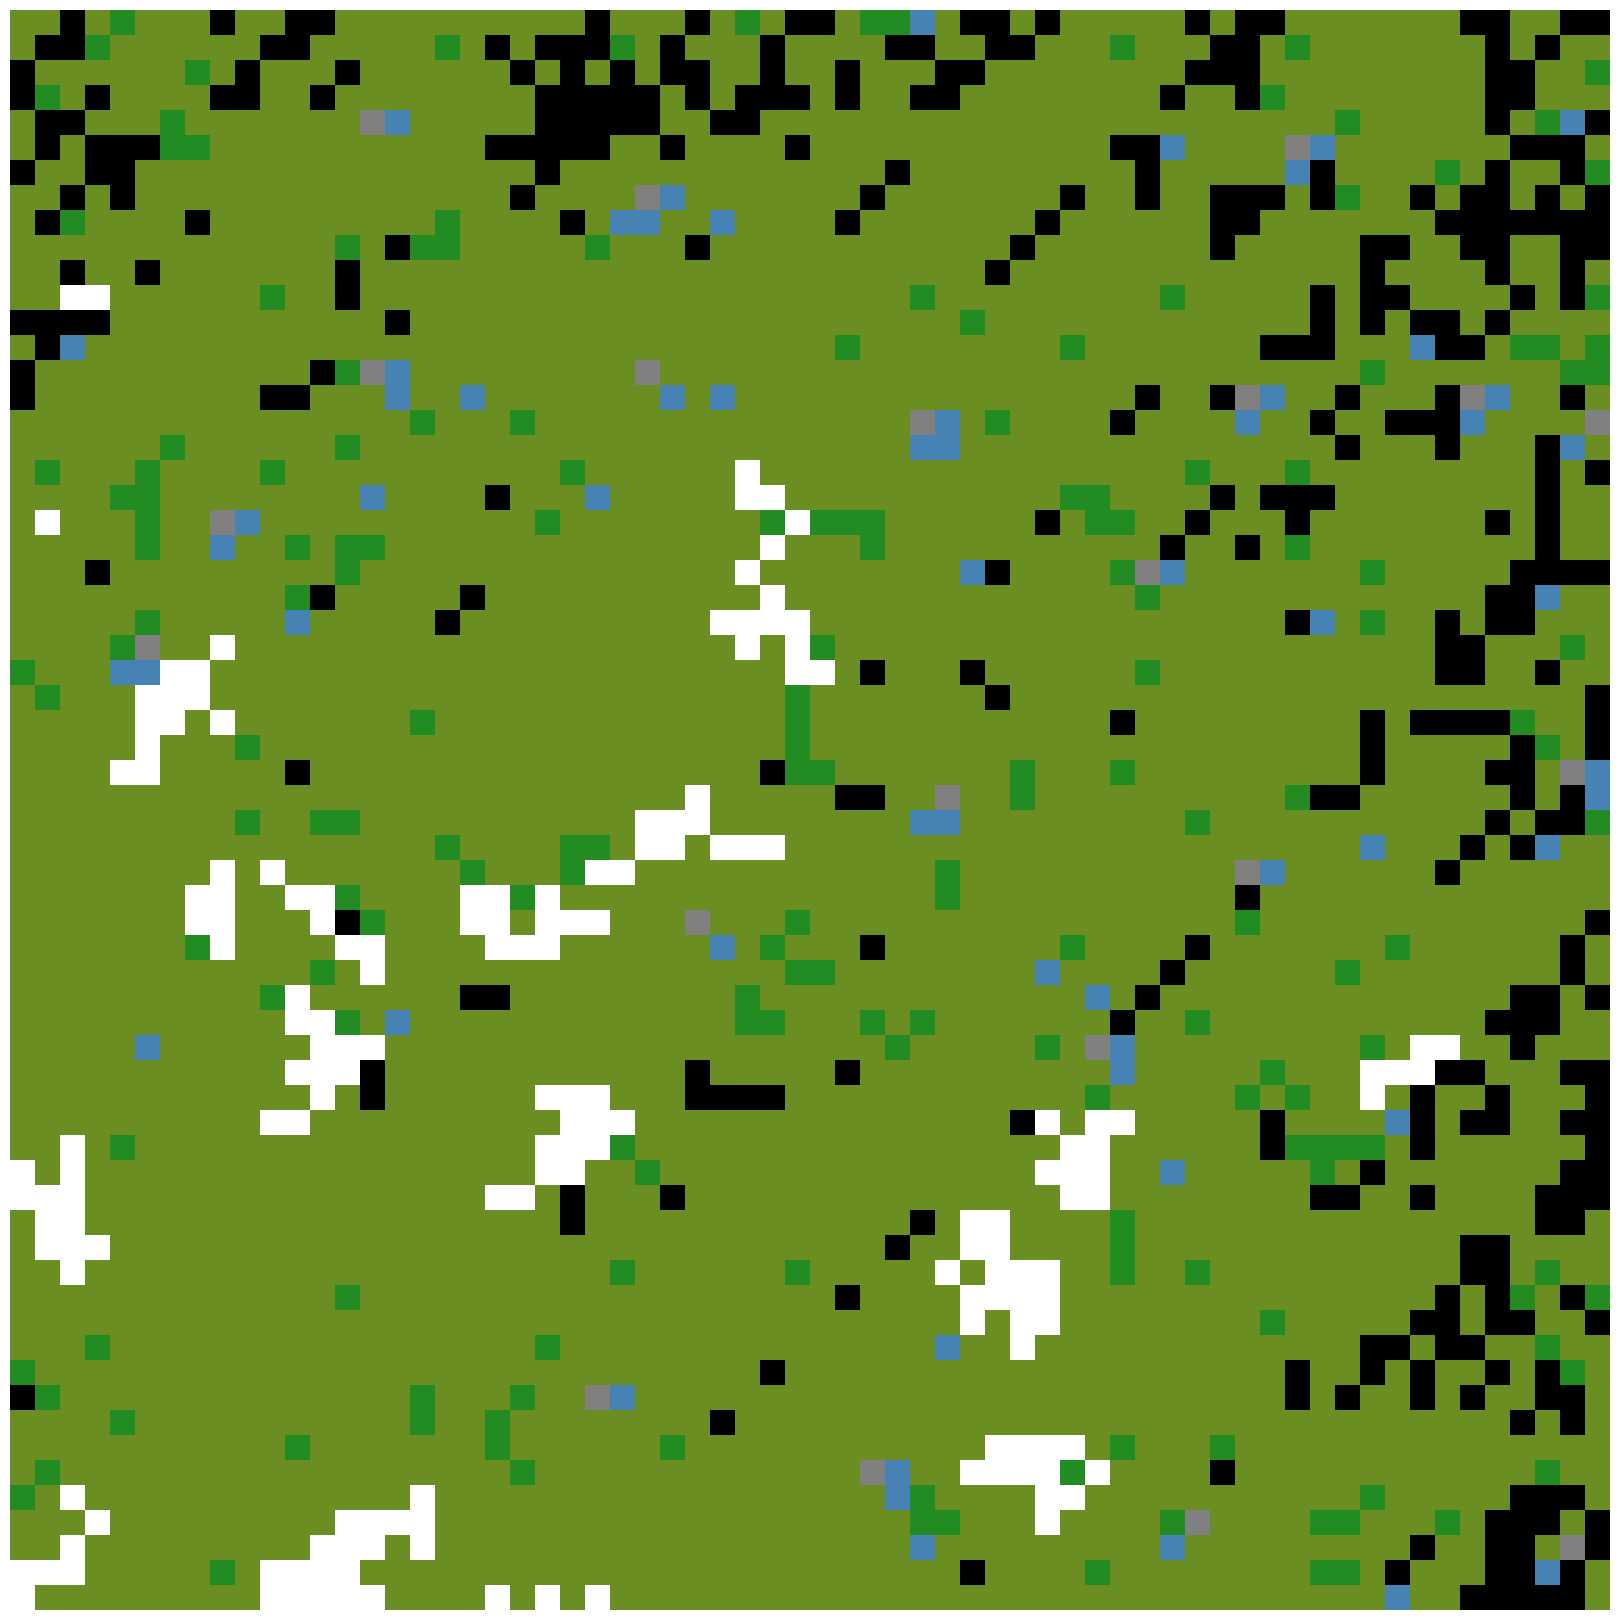

In [61]:
def update(frame):
    im.set_data(Sim.landscape)
    ax.axis('off')
    Sim.step(frame)
    return [im]

colors_list = ['steelblue', 'grey','black', 'olivedrab', 'forestgreen', 'orange', 'white']
cmap = colors.ListedColormap(colors_list)
bounds = [-3, -2, -1, 0, 1, 2, 3, 4]
norm = colors.BoundaryNorm(bounds, cmap.N)

Sim = WFSim(h=64, w=64) #initializing the simulation

fig, ax = plt.subplots(figsize=(16,16))
im = ax.imshow(Sim.landscape, cmap=cmap, norm=norm)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

ani = animation.FuncAnimation(fig, update, frames=80, interval=20) #frames - the number of steps in the simulation
ani.save('clouds.gif', fps=1.5, savefig_kwargs={'pad_inches':0})
plt.show()

In [4]:
colors_list = ['steelblue', 'grey','black', 'olivedrab', 'forestgreen', 'orange', 'white']
cmap = colors.ListedColormap(colors_list)
bounds = [-3, -2, -1, 0,1,2,3, 4]
norm = colors.BoundaryNorm(bounds, cmap.N)

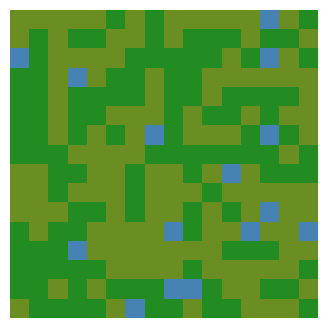

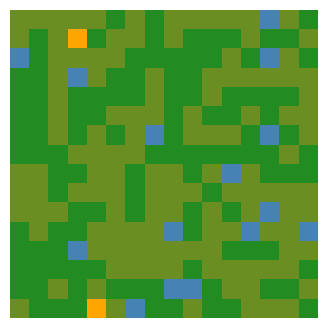

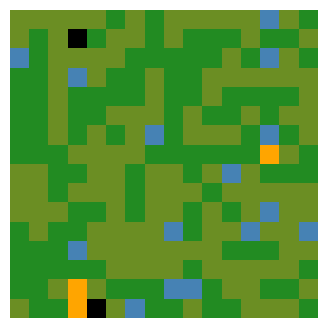

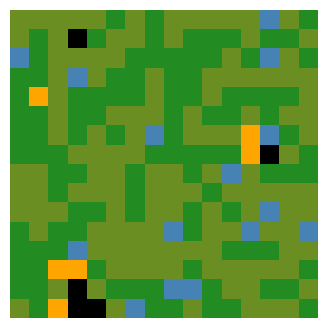

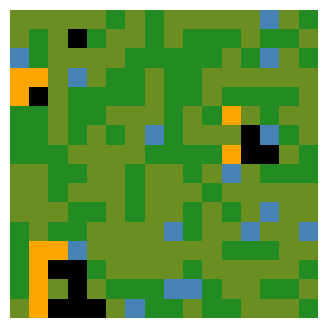

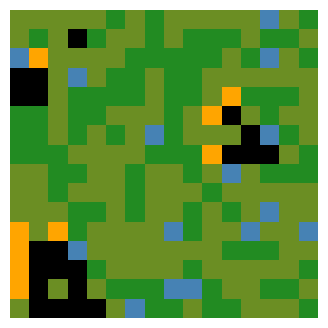

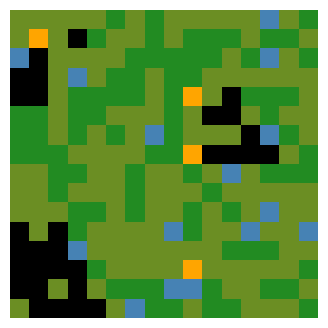

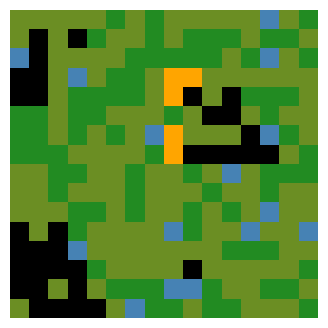

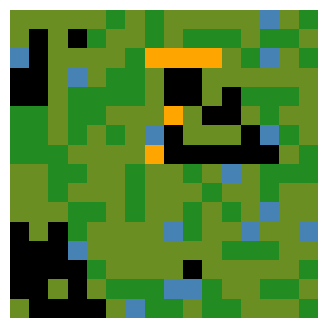

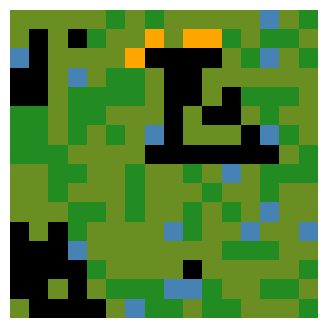

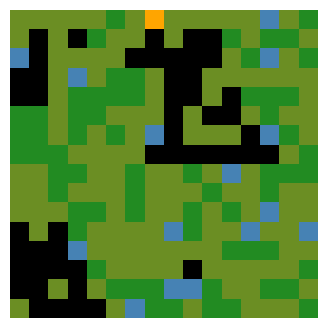

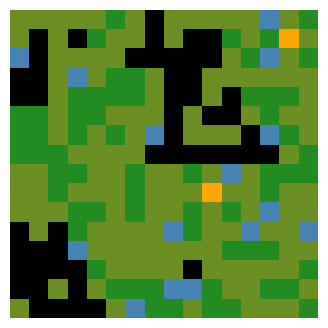

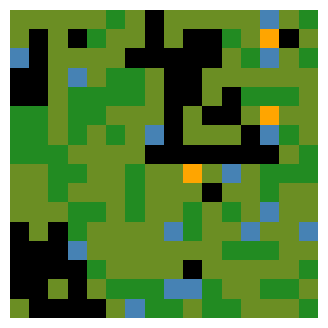

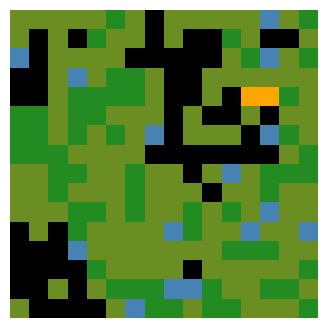

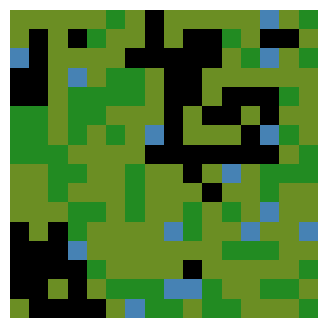

In [80]:
Sim = WFSim()
for step in range(15):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    plt.imshow(Sim.landscape, axes=ax, cmap=cmap, norm=norm)
    ax.set_axis_off()
    plt.show()
    Sim.step(step)

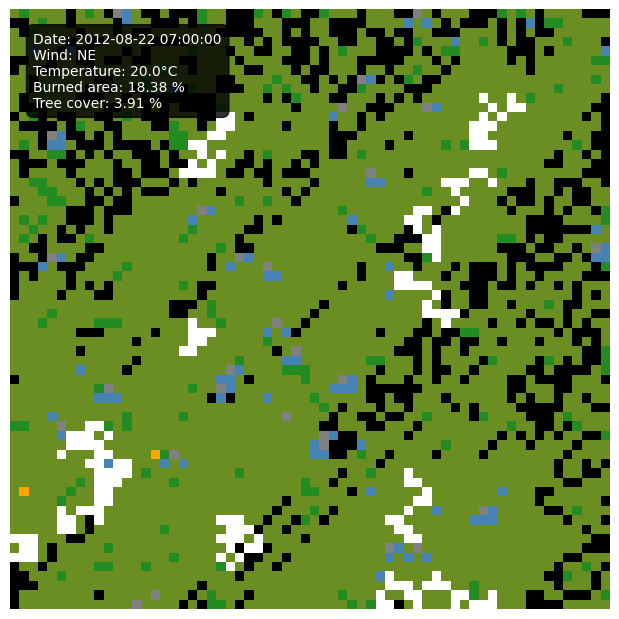

In [75]:
def update(frame):
    im.set_data(Sim.landscape)
    # info_box = Rectangle((-0.2, -0.1), 0.6, 0.25, transform=ax.transAxes,
    #                  color='black', alpha=0.5, edgecolor='black')
    #ax.add_patch(info_box)
    info_text = (
        f"Date: {initial_date + timedelta(hours=frame)}\n"
        f"Wind: {Sim.wind}\n"
        f"Temperature: {round(Sim.temp[frame%24],1)}°C\n"
        f"Burned area: {Sim.burned_ratio} %\n"
        f"Tree cover: {Sim.tree_cover} %"
    )
    text.set_text(info_text)
    ax.axis('off')
    Sim.step(frame)
    return [im]
    
Sim = WFSim(h=64, w=64) 
initial_date = datetime(2012, 8, 19, 0)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(Sim.landscape, cmap=cmap, norm=norm)
text = ax.text(2, 10, "", ha='left', fontsize=10, color='white', 
        bbox=dict(facecolor='black', alpha=0.8, edgecolor='black',boxstyle='round,pad=0.5'))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 12, wspace = 0)

ani = animation.FuncAnimation(fig, update, frames=80, interval=20)
ani.save('animation.gif', fps=1.5, savefig_kwargs={'pad_inches':0})
plt.show()